# Sparkify Project

In this project, we work on manipulating a large dataset with Spark to engineer relevant features for predicting churn using the Spark MLlib to build a classification model.

Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

This project covers:
Loading large datasets into Spark and manipulate them using Spark SQL and Spark Dataframes.
Using the  machine learning APIs within Spark ML to build and tune models to predict churn.

## Table Of Contents

- [Getting To Know Our Dataset](# introduction)
- [Exploratory Data Analysis](# exploratory-data-analysis)
- [Feature Engineering](# feature-engineering)
- [Modeling](# modeling)
- [Conclusion](# conclusion)

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, concat, udf, avg, count, asc, desc, isnan, isnull, lit, when, mean, percent_rank, dense_rank
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum, max as Fmax, min as Fmin, round as Fround


from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, Normalizer, PCA, RegexTokenizer, VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import gc
import re

import time

%matplotlib inline

sns.set_style(style="whitegrid");
sns.set_palette("pastel");

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .master("local") \
        .appName('Sparkify Project') \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or session ids. 

In [3]:
data_path = 'mini_sparkify_event_data.json'

In [4]:
#Importing the mini dataset
df = spark.read.json(data_path)
df.persist();

In [5]:
df.limit(3).toPandas().head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


We can start exploring the dataset by looking at the dataset.

## Getting To Know Our Dataset
In this section, we check our data's schema, our datatypes and we search through the null and duplicated rows.

#### A. Data Types:

We can print the schema and look at the data types to verify if they show up as expected.

In [135]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



This rounds up the section on our preliminary analysis. We will move on to data cleaning.

### Missing Data:

We start with investigating missing data. What columns have missing data and where do we need to fill in or drop missing data?

The first thing we will do to ensure consistency is to ensure empty strings or nans or are read the same way to ensure consistency for our analysis.

In [136]:
#replacing empty strings with nulls
for column in df.columns:
    df = df.withColumn(column, when(col(column) == '', None).otherwise(col(column)))

In [137]:
print(f'We have {df.count()} rows and {len(df.columns)} columns in our dataset.')

We have 286500 rows and 18 columns in our dataset.


How many of these columns are unique:

In [138]:
print(f'We have {df.select("userId").distinct().count()} unique users')

We have 226 unique users


In [139]:
def get_null_columns(df):
    '''
    Args
    df (dataframe) - A spark dataframe
    
    Returns
    null_col_df (dataframe) - A spark dataframe with missing columns summed.
    
    Description
    Takes a spark dataframe and counts the number of missing values in each column
    '''
    columns = df.columns
    
    missing_col_count = [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
    
    null_dfs = df.select(missing_col_count)
    
    return null_dfs

In [140]:
missing_by_col = get_null_columns(df).toPandas()
missing_by_col

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,8346


We can make a plot to easily visualize our data:

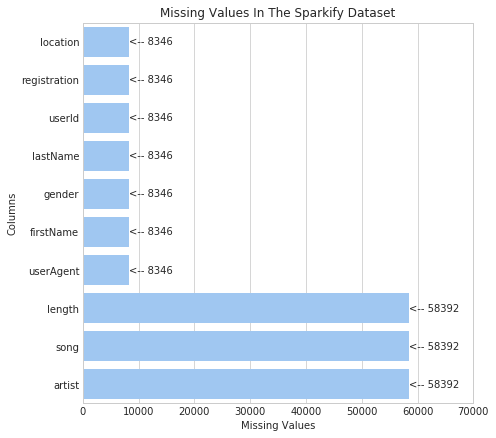

In [141]:
#visualizing our missing data
missing_users_by_col = missing_by_col.T.reset_index().rename(columns={'index':'Columns',0:'Missing Values'})
missing_users_by_col = missing_users_by_col.sort_values('Missing Values')
missing_users_by_col = missing_users_by_col[missing_users_by_col['Missing Values'] > 0]

f, ax = plt.subplots(figsize=(7,7))
sns.barplot(x='Missing Values', y='Columns', color=sns.color_palette()[0], data=missing_users_by_col, ax=ax)
ax.set_xticks(range(0,80000,10000))
ax.set_title('Missing Values In The Sparkify Dataset');

for i in range (missing_users_by_col.shape[0]):
    values = missing_users_by_col['Missing Values'].iloc[i]
    text = f'<-- {values}'
    ax.text(values+1, i, text, va='center')

An interesting observation from the plot is that, where data is missing, the data might seems to be missing from the same users across the dataset. We can take a look at these subset of users.

**1.  Missing Data: Investigating Data with missing Registration:**

We start with with our first identified source of missing data, the registration column. From the results, our first intuition is to inspect unregistered users as a primary reason behind the missing data here.

In [142]:
#A print out of the data
null_registers = df.filter(df.registration.isNull())
null_registers.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,None
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,None
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,None
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,None
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,None


In [143]:
print(f'We have {null_registers.count()} users with no registration information')
print('Their authentication categories are:')
null_registers.groupby('auth').count().show()

We have 8346 users with no registration information
Their authentication categories are:
+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [144]:
null_register_users = get_null_columns(null_registers).toPandas()
null_register_users

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,8346,0,8346,8346,0,8346,8346,0,8346,0,0,8346,0,8346,0,0,8346,8346


We can see that a large number of the missing data is from unregistered users. We can also, see that these users are missing some other data. **This missing data will not really serve as a source of information for the task we have to accomplish and so we can afford to drop them in the cleaning data section.**

**2.  Missing Data: Investigating Data with missing Artists:**

*Looking at our plot, Our largest sources of missing data are from the `'artist', 'length' and 'song'` columns.* 

Clearly some of this is from the unregistered users. But overall, considering they have the same count on missing values, we may suspect that this data is missing from the same rows. We will ignore out the rows with no registration since we already understand the problem.

In [145]:
#Looking at rows with null artist data
missing_artists = df.filter(df.artist.isNull() & df.registration.isNotNull())
not_missing = df.filter(df.artist.isNotNull() & df.registration.isNotNull())
missing_artists.limit(4).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


We can confirm that these columns are missing from the same rows.

In [146]:
print('From the null artists subset, we have:')
print(f'{missing_artists.select("song").count()} missing songs')
print(f'{missing_artists.select("length").count()} missing length')
print(f'{missing_artists.select("artist").count()} missing artists')

From the null artists subset, we have:
50046 missing songs
50046 missing length
50046 missing artists


Nothing really stands out from the dataframe readout. We can however start our analysis by simply looking at the columns we anticipate we could find problems. Let's investigate the `status` `page` and `method` columns to see if anything stands out. 

In [147]:
missing_artists.groupby('status').count().show()

+------+-----+
|status|count|
+------+-----+
|   307|23184|
|   404|  252|
|   200|26610|
+------+-----+



In [148]:
not_missing.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   200|228108|
+------+------+



For the missing group we can see status codes of 404 and 307 present as well 200 which also appears in the subset with no missing data.

In [149]:
not_missing.groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [150]:
missing_artists.groupby('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|   63|
|         Thumbs Down| 2546|
|                Home|10082|
|           Downgrade| 2055|
|         Roll Advert| 3933|
|              Logout| 3226|
|       Save Settings|  310|
|Cancellation Conf...|   52|
|               About|  495|
|            Settings| 1514|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|           Thumbs Up|12551|
|                Help| 1454|
|             Upgrade|  499|
|               Error|  252|
|      Submit Upgrade|  159|
+--------------------+-----+



Looking at the columns from which data is missing, we can see a host of other link pages. The 'Next Song' page is not present here and this provides us with more information. 

The pages with missing information are interactions by a user with sparkify where they are not playing songs. This also explains why the response codes are all '200' as 200 is the OK success status response code for a successful request. 

One more look at the method column should confirm this hyothesis.

In [151]:
not_missing.groupby('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|228108|
+------+------+



In [152]:
missing_artists.groupby('method').count().show()

+------+-----+
|method|count|
+------+-----+
|   PUT|29710|
|   GET|20336|
+------+-----+



Rooting the source of this missing data tells us that the absence of data itself encodes information. It seems very valid to the task at hand and therefore we will keep information.

### Duplicated Data:

Here we proceed to check for data duplication in the dataset.

In [6]:
count_without_duplicates = df.dropDuplicates().count()

print(f'We have {df.count()-count_without_duplicates} duplicated columns')

We have 0 duplicated columns


We have no duplicate data. This is good.

This rounds up the section of preliminary analysis. We will move on to data cleaning.

## Cleaning Data

After a preliminary analyis, we have only one task outlined for data cleaning. This is dropping the information from "Guest and Logged Out" users as we have no real need for them in this analysis. 

In [7]:
data_count = df.count()
print(f'Before dropping we have {data_count} datapoints')

df = df.dropna(how = "any", subset = ["registration"])

second_count = df.count()
print(f'After dropping we have {second_count} datapoints')

print(f'We dropped {data_count - second_count} datapoints')

Before dropping we have 286500 datapoints
After dropping we have 278154 datapoints
We dropped 8346 datapoints


In [14]:
#del not_missing, missing_artists, missing_by_col, missing_users_by_col
#del column, get_null_columns, null_register_users, null_registers
#del count_without_duplicates, data_count, second_count
#gc.collect();

# Exploratory Data Analysis
We are done with cursory checks on our data to verify its validity. In this section, we explore perform more indepth exploration of our data with reference to our label for classification.

### Defining Our Churn Metric

We have done some preliminary analysis, now we'll proceed to create a column `Churn` to use as the label our model. We will use the `Cancellation Confirmation`  and `Submit Downgrade` events to define churn, which happen for both paid and free users. 

Basically, if a user Downgrades from paid or Cancels their subscription, then we consider this as churn.

In [8]:
#A look at the cancellation confirmation page
df.filter(df.page=='Cancellation Confirmation').limit(2).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Cancelled,Adriel,M,104,Mendoza,None,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
1,None,Cancelled,Diego,M,56,Mckee,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32


In [9]:
#Confirming the auth page link
df.filter(((df.page=='Cancellation Confirmation') & 
           (df.auth!='Cancelled')) | 
          ((df.page!='Cancellation Confirmation')
          & (df.auth=='Cancelled'))).count()

0

A passing note that when the users clicks the cancellation confirmation page, it is linked an `auth` confirmation with the value Cancelled. 

We will select users who unsubscribe/downgrade and we set those entries to a boolean 1 others who are still subscribed to 0. 

Then use a function to distinguish each user's data as either pre or post churn events where there exists.

In [10]:
df = df.withColumn('unsubscribed',
                   when((col('page') == 'Cancellation Confirmation') | (col('page') == 'Submit Downgrade'), 1) \
                  .otherwise(0))

In [11]:
#segmenting by users and backfilling cancellation status
windowval_bf = Window.partitionBy("userId") \
                  .orderBy(desc("ts")) \
                  .rangeBetween(Window.unboundedPreceding, 0)
    
df = df.withColumn("bf",
                   Fsum("unsubscribed").over(windowval_bf))

#segmenting by users and forwardfilling cancellation status
windowval_ff = Window.partitionBy("userId") \
                  .orderBy("ts") \
                  .rangeBetween(Window.unboundedPreceding, 0)

df = df.withColumn("churn",
                   Fsum("bf").over(windowval_ff))

In [12]:
df = df.withColumn('churn',
                   when(col('churn') > 0, 1) \
                  .otherwise(0))
df = df.drop('bf')

In [13]:
df.filter(df.churn == 1) \
  .select('userId').dropDuplicates().limit(5).show(5)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
+------+



We can take a look at one of the users who unsubscribed

In [14]:
df.filter(df.userId == 125).sort(desc('ts')).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,unsubscribed,churn
0,None,Logged In,Mason,M,9,Hart,NaN,free,"Corpus Christi, TX",PUT,Cancel,1533157139000,174,None,307,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
1,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,1,1
2,None,Logged In,Mason,M,8,Hart,NaN,free,"Corpus Christi, TX",GET,Roll Advert,1533157139000,174,None,200,1539318917000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
3,Bonobo,Logged In,Mason,M,7,Hart,323.81342,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Kota,200,1539318906000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
4,Robert Johnson,Logged In,Mason,M,6,Hart,178.41587,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,They're Red Hot,200,1539318728000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
5,We Are The Fallen,Logged In,Mason,M,5,Hart,213.60281,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Don't Leave Me Behind,200,1539318515000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
6,Ready For The World,Logged In,Mason,M,4,Hart,391.26159,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Love You Down,200,1539318124000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
7,Nickelback,Logged In,Mason,M,3,Hart,210.83383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Leader Of Men (Album Version),200,1539317914000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
8,Betty Boo,Logged In,Mason,M,2,Hart,203.23220,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,I'm On My Way,200,1539317711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1
9,The Notorious B.I.G.,Logged In,Mason,M,1,Hart,230.03383,free,"Corpus Christi, TX",PUT,NextSong,1533157139000,174,Hypnotize(Album Version),200,1539317481000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1


In [15]:
df = df.withColumn('status', when(col('churn') == 0, 'Subscribed').otherwise('Unsubscribed'))

We can count the number of users that unsubscribed from the service.

In [16]:
churn_summary = df.select(['userId', 'status']) \
                  .dropDuplicates() \
                  .groupby('status') \
                  .agg(count(col('status')).alias('summary'))

In [17]:
churn_summary.show()
churn_df = churn_summary.toPandas()

+------------+-------+
|      status|summary|
+------------+-------+
|  Subscribed|    133|
|Unsubscribed|     92|
+------------+-------+



We can check the unique user counts to confirm the numbers above.

In [18]:
users = df.select('userId').distinct().count()
print(f'We have {users} distinct users')

We have 225 distinct users


From the table above, we can see a summary count. A barplot would also serve well for this.

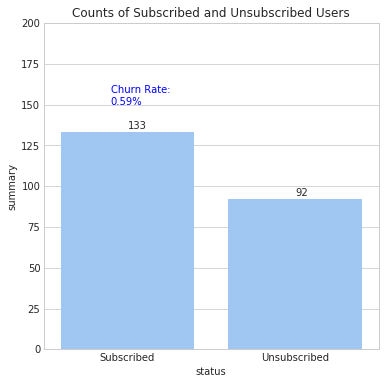

In [19]:
churn_rate = churn_df['summary'][0] / churn_df['summary'].sum()

fig, ax = f, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='status', y='summary',
            color=sns.color_palette()[0],
            data=churn_df, ax=ax);
ax.set_title('Counts of Subscribed and Unsubscribed Users');
ax.set_yticks(range(0,205,25))

for i in range (churn_df.shape[0]):
    values = churn_df['summary'].iloc[i]
    ax.text(i, values+4, values, va='center')

ax.annotate(f'Churn Rate: \n{churn_rate:.2f}%',(-0.1,150),
            color='blue');

In [20]:
print(f'Our churn rate is {churn_rate:.3f}')

Our churn rate is 0.591


It turns out have an unbalanced dataset. We will have to keep this in mind when creating features and modeling.

In [22]:
#del churn_rate, churn_summary, churn_df, users, fig, ax, windowval_bf, windowval_ff
#gc.collect();

### Exploring Data
We now proceed to perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We will start explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Since the churn is a categorical variable, most of our comparison plots wil be Categorical-Categorical or Categorical-Numeric Comparisons.

#### Opening with Artist popularity

We examine what users are listening to

In [189]:
artists_df = df.select('artist').dropna().groupBy("Artist").count()
artists_df = artists_df.orderBy(desc('count'))
artists_df.show(5)

+--------------------+-----+
|              Artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
+--------------------+-----+
only showing top 5 rows



In [191]:
artists_df = artists_df.limit(20).toPandas()

artists_df.head()

,Artist,count
0,Kings Of Leon,1841
1,Coldplay,1813
2,Florence + The Machine,1236
3,Dwight Yoakam,1135
4,BjÃÂ¶rk,1133


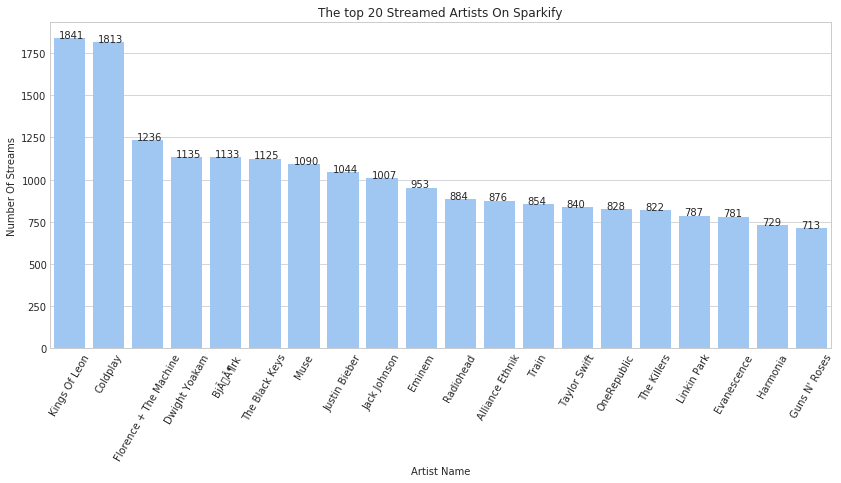

In [199]:
plt.figure(figsize=(14,6))

ax = sns.barplot(x='Artist', y='count', data = artists_df, color=sns.color_palette()[0])
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Artist Name');
plt.xticks(rotation=60)
plt.ylabel('Number Of Streams')

plt.title('The top 20 Streamed Artists On Sparkify');

In [200]:
del artists_df, ax
gc.collect();

#### 1 Exploring Gender

Here we explore gender differences lengths between subscribed and unsubscribed users. We try to examine between both categories.

In [149]:
gender_df = df.select(['userId', 'status', 'gender']) \
              .dropDuplicates() \
              .groupBy('gender', 'status') \
              .count() 
        
gender_df.show(5)

gender_df = gender_df.toPandas()

+------+------------+-----+
|gender|      status|count|
+------+------------+-----+
|     M|Unsubscribed|   49|
|     F|Unsubscribed|   43|
|     M|  Subscribed|   72|
|     F|  Subscribed|   61|
+------+------------+-----+



We want to view the differences across gender. We can use a clustered bar chart to see 

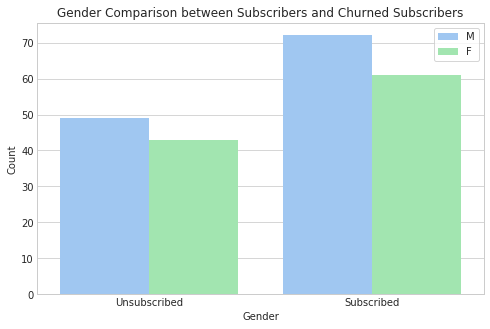

In [150]:
plt.figure(figsize=(8,5))
sns.barplot(x='status', y='count', hue='gender', data = gender_df)
plt.xlabel('Gender');
plt.ylabel('Count');
plt.title('Gender Comparison between Subscribers and Churned Subscribers');
plt.legend(frameon=True);

We want to view the differences across gender. We can use a clustered bar chart to see the differences.

In [151]:
gender_df = gender_df.sort_values(['gender','status'])

gender_unsubscribed = gender_df[gender_df['status']=='Unsubscribed']['count']

gender_sum = gender_df.groupby('gender').sum()['count']

churn_rate = gender_unsubscribed.values / gender_sum.values
print('The churn rate by gender is: ')
for i, categ_class in enumerate(gender_df.gender.unique()):
    print(f'{categ_class}: {churn_rate[i]:.2f}%')

The churn rate by gender is: 
F: 0.41%
M: 0.40%


There is not much information to be gleaned here from the gender features though I would like to see what might come out of our model in terms of feature importance.

In [152]:
del gender_df, gender_sum, churn_rate, categ_class, gender_unsubscribed
gc.collect();

#### 2 Exploring itemInSession and 'sessionId'

Here we explore the number of items in a session as well as the number of sessions by each user. There are a number of ways we can explore this feature. We can look both the maximum number of items in a session by each user in each group. We can also explore the average number of items in a session by each user in each group and search for differences.

First, we try to understand the iteminsession variable by looking at one user and the subsequent values across the rows.

In [138]:
df.where('userId == 10').orderBy('itemInSession').limit(20).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,unsubscribed,churn
0,Big & Rich,Logged In,Brycen,M,0,Bradley,200.09751,paid,"Laurel, MS",PUT,NextSong,1538159495000,1981,Save A Horse [Ride A Cowboy] (Album Version),Subscribed,1542611650000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
1,Alexis & Fido,Logged In,Brycen,M,0,Bradley,174.28853,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Bartender,Subscribed,1539833923000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
2,Sea Wolf,Logged In,Brycen,M,0,Bradley,265.53424,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Ses Monuments,Subscribed,1538965220000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
3,John Fred & His Playboy Band,Logged In,Brycen,M,0,Bradley,171.80689,paid,"Laurel, MS",PUT,NextSong,1538159495000,1414,Judy In Disguise,Subscribed,1541255262000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
4,None,Logged In,Brycen,M,0,Bradley,NaN,paid,"Laurel, MS",GET,Home,1538159495000,1047,None,Subscribed,1540850546000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
5,Godley & Creme,Logged In,Brycen,M,0,Bradley,237.81832,paid,"Laurel, MS",PUT,NextSong,1538159495000,1592,Cry,Subscribed,1542310466000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
6,Avril Lavigne,Logged In,Brycen,M,1,Bradley,214.15138,paid,"Laurel, MS",PUT,NextSong,1538159495000,1981,Alice,Subscribed,1542611850000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
7,George Baker Selection,Logged In,Brycen,M,1,Bradley,200.43710,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Morning Sky,Subscribed,1538965485000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
8,Crosby_ Stills & Nash,Logged In,Brycen,M,1,Bradley,444.05506,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Suite: Judy Blue Eyes [Remastered LP Version],Subscribed,1539834097000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0
9,Phoenix,Logged In,Brycen,M,1,Bradley,207.15057,paid,"Laurel, MS",PUT,NextSong,1538159495000,1592,Holdin' On Together,Subscribed,1542310703000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0,0


It seems the item in session is a monitor on the interactivity of each client with the application. For each action the user takes, an increasing session id in created. We can select this information to see what facts we can draw out.

In [139]:
#Calculating summary functions
session_df = df.groupby(['userId','sessionId']) \
               .agg(Fmax(col('itemInSession')) \
                    .alias('itemsInSession'),
                    Fmin(col('ts')) \
                    .alias('sessionStart'), 
                    Fmax(col('ts')) \
                    .alias('sessionEnd')) \
               .orderBy(asc('userId'), asc('sessionId'))

#Calculating the session length
session_df = session_df.withColumn("sessionLength", 
                                   Fround((col("sessionEnd") \
                                    .cast("long") - 
                                    col("sessionStart")
                                    .cast("long")) /(60.*1000.), 2))

In [140]:
status_df = df.select(col('userId').alias('id'),col('status')).dropDuplicates()


session_df = session_df.join(status_df,
                             session_df.userId == status_df.id, 
                             'left').dropDuplicates()

session_df = session_df.select('userId','sessionId','itemsInSession',
                               'sessionLength','status')

session_df.show(5)

+------+---------+--------------+-------------+----------+
|userId|sessionId|itemsInSession|sessionLength|    status|
+------+---------+--------------+-------------+----------+
|100010|       31|            39|       111.88|Subscribed|
|100010|       78|             8|        22.55|Subscribed|
|100010|      113|            57|       148.43|Subscribed|
|100010|      118|            59|       165.27|Subscribed|
|100010|      133|            73|       213.25|Subscribed|
+------+---------+--------------+-------------+----------+
only showing top 5 rows



In [141]:
session_df = session_df.toPandas()
session_df.head()

,userId,sessionId,itemsInSession,sessionLength,status
0,100010,31,39,111.88,Subscribed
1,100010,78,8,22.55,Subscribed
2,100010,113,57,148.43,Subscribed
3,100010,118,59,165.27,Subscribed
4,100010,133,73,213.25,Subscribed


Now that we have this data, we can start to look through a number of ideas. 

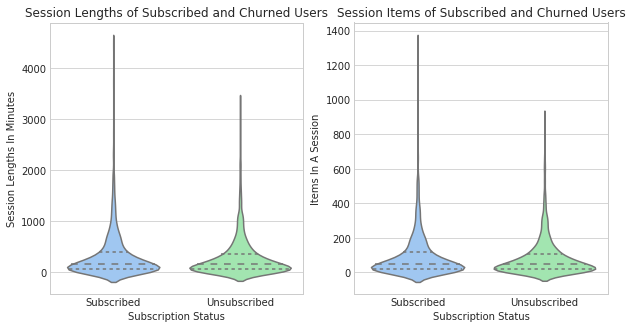

In [142]:
# plot the distribution
f, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
sns.violinplot(x='status',y='sessionLength', data=session_df, inner='quartile', ax =ax0)
ax0.set_ylabel('Session Lengths In Minutes');
ax0.set_xlabel('Subscription Status');
ax0.set_title('Session Lengths of Subscribed and Churned Users');

sns.violinplot(x='status',y='itemsInSession', data=session_df, inner='quartile', ax =ax1)
ax1.set_ylabel('Items In A Session');
ax1.set_xlabel('Subscription Status');
ax1.set_title('Session Items of Subscribed and Churned Users');

In [143]:
avg_session_df = session_df.groupby(['userId'])['sessionLength','itemsInSession'].mean().reset_index()
avg_session_df.head()

,userId,sessionLength,itemsInSession
0,10,459.748333,135.500000
1,100,316.519143,93.228571
2,100001,148.157500,49.250000
3,100002,201.185000,54.000000
4,100003,99.120000,41.000000


In [144]:
status_df = session_df[['userId','status']].drop_duplicates()

avg_session_df = avg_session_df.merge(status_df, on='userId', how='left')

avg_session_df.head()

,userId,sessionLength,itemsInSession,status
0,10,459.748333,135.500000,Subscribed
1,100,316.519143,93.228571,Unsubscribed
2,100001,148.157500,49.250000,Unsubscribed
3,100002,201.185000,54.000000,Subscribed
4,100003,99.120000,41.000000,Unsubscribed


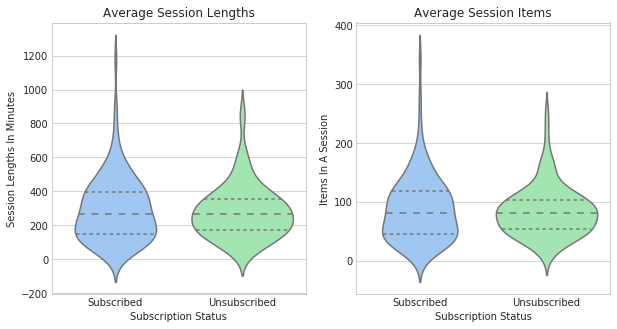

In [149]:
# plot the distribution
f, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
sns.violinplot(x='status',y='sessionLength', data=avg_session_df, inner='quartile', ax =ax0)
ax0.set_ylabel('Session Lengths In Minutes');
ax0.set_xlabel('Subscription Status');
ax0.set_title('Average Session Lengths');

sns.violinplot(x='status',y='itemsInSession', data=avg_session_df, inner='quartile', ax =ax1)
ax1.set_ylabel('Items In A Session');
ax1.set_xlabel('Subscription Status');
ax1.set_title('Average Session Items');

The average session times however are giving slightly different plots. On the subscribed users, we have a slimmer plot with an almost unnoticeable bump that is might be a small bimodal curvature. Let's take one more look at this.

In [146]:
avg_session_df.groupby('status')['sessionLength'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Subscribed,133.0,293.476317,189.706095,7.00,146.880000,264.275000,392.810667,1179.900
Unsubscribed,92.0,280.489041,157.087863,29.57,173.333816,266.262542,353.522315,872.357


In [147]:
avg_session_df.groupby('status')['itemsInSession'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Subscribed,133.0,87.555666,55.094537,5.0,44.727273,81.000000,118.500000,342.111111
Unsubscribed,92.0,84.370840,42.707571,10.0,52.916667,80.980603,103.154306,251.900000


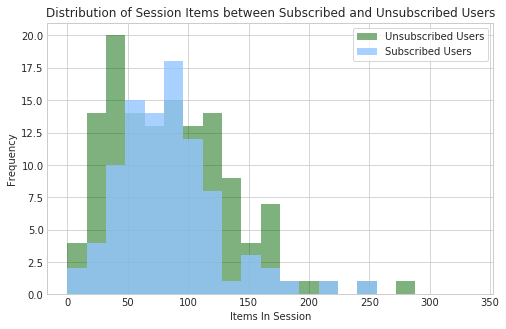

In [148]:
# plot the distribution
bins = range(0, int(avg_session_df['itemsInSession'].max())+8, 16)
plt.figure(figsize=(8,5))

plt.hist(x='itemsInSession', alpha=0.5,
         bins = bins, data=avg_session_df.query('status == "Subscribed"'),
         color='darkgreen',  label='Unsubscribed Users');

plt.hist(x='itemsInSession', alpha=0.8,
         bins = bins, data=avg_session_df.query('status == "Unsubscribed"'),
         color=sns.color_palette()[0],  label='Subscribed Users');

plt.xlabel('Items In Session');
plt.ylabel('Frequency');
plt.title('Distribution of Session Items between Subscribed and Unsubscribed Users');
plt.legend(loc=1, frameon=True);

We can still see the same patterns here. While not largely exaggerated, the subscribed users seem to have a more consistent interaction (on average) with the application across time. This could be for a number of reasons. 

A better spread over time could be one reason, or it could be simply be a feature of subscribers we will want to target. We will entertain this more when we see registration periods.

In [197]:
del session_df, status_df, avg_session_df
gc.collect();

104776

#### 3 Exploring Song Lengths

Here we explore song lengths between subscribed and unsubscribed users to see if we can spot and visible differences between distributions.

In [46]:
lengths_df = df.select(['userId','status','length'])
lengths_df.show(5)

+------+----------+---------+
|userId|    status|   length|
+------+----------+---------+
|100010|Subscribed|202.97098|
|100010|Subscribed|196.54485|
|100010|Subscribed|263.13098|
|100010|Subscribed|     null|
|100010|Subscribed|316.23791|
+------+----------+---------+
only showing top 5 rows



Some quick summary data on song lengths. We will drop the null values here to prevent some quirky errors

In [47]:
lengths_df = lengths_df.toPandas().dropna()

lengths_df.groupby('status')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Subscribed,113563.0,249.132271,97.701025,0.78322,199.88853,234.63138,277.15873,3024.66567
Unsubscribed,114545.0,249.102223,100.733543,2.16771,199.88853,234.31791,277.15873,3024.66567


Since our length data is numerical a better visual is to plot the distribution of song lengths for both subscribed and unsubscribed users to see if we can find any visible differences.

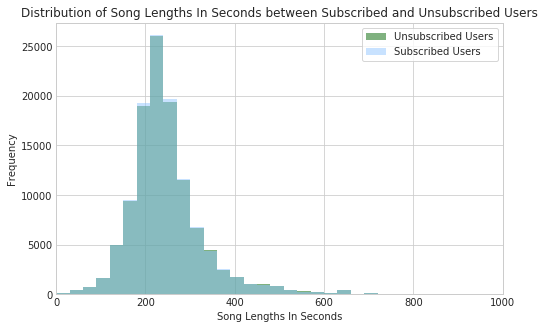

In [48]:
# plot the distribution
bins = range(0, int(lengths_df['length'].max()), 30)
plt.figure(figsize=(8,5))
plt.hist(x='length', alpha=0.5,
         bins = bins, data=lengths_df.query('status == "Subscribed"'),
         color='darkgreen',  label='Unsubscribed Users');
plt.hist(x='length', alpha=0.5,
         bins = bins, data=lengths_df.query('status == "Unsubscribed"'),
         color=sns.color_palette()[0],  label='Subscribed Users');
plt.xlim(0,1000) #zoom in on a small subset of features.
plt.xlabel('Song Lengths In Seconds');
plt.ylabel('Frequency');
plt.title('Distribution of Song Lengths In Seconds between Subscribed and Unsubscribed Users');
plt.legend(loc=1, frameon=True);

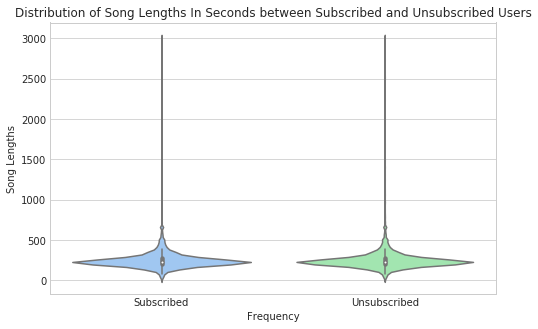

In [49]:
# plot the distribution
plt.figure(figsize=(8,5))
sns.violinplot(x='status',y='length', data=lengths_df)
plt.ylabel('Song Lengths');
plt.xlabel('Frequency');
plt.title('Distribution of Song Lengths In Seconds between Subscribed and Unsubscribed Users');
plt.legend(loc=1, frameon=True);

We see two very identical distributions here and should not expect otherwise. Most songs are of standard length nowadays and our users should have no impact on this. 

The vox has a good article on this: [History Of The Three-Minute Pop Song](https://www.vox.com/2014/8/18/6003271/why-are-songs-3-minutes-long)

In [50]:
del lengths_df
gc.collect();

#### 4 Exploring Level

We explore the relationships between levels and churn 

In [138]:
level_df = df.select(['userId', 'status', 'level']) \
              .dropDuplicates() \
              .groupBy('level', 'status') \
              .count() 
        
level_df.show(5)

level_df = level_df.toPandas()

+-----+------------+-----+
|level|      status|count|
+-----+------------+-----+
| paid|Unsubscribed|   76|
| free|  Subscribed|  109|
| paid|  Subscribed|   89|
| free|Unsubscribed|   86|
+-----+------------+-----+



We want to view the differences across gender. We can use a clustered bar chart to see 

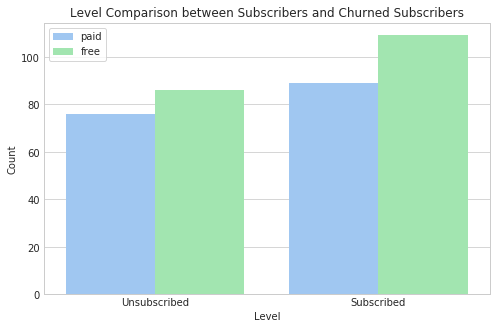

In [139]:
plt.figure(figsize=(8,5))
sns.barplot(x='status', y='count', hue='level', data = level_df)
plt.xlabel('Level');
plt.ylabel('Count');
plt.title('Level Comparison between Subscribers and Churned Subscribers');
plt.legend(frameon=True);

We want to view the differences across level. We can use a clustered bar chart to see the differences.

In [140]:
level_df = level_df.sort_values(['level','status'])

level_unsubscribed = level_df[level_df['status']=='Unsubscribed']['count']
level_unsubscribed.values

level_sum = level_df.groupby('level').sum()['count']
level_sum.values

churn_rate = level_unsubscribed.values / level_sum.values
print('The churn rate by level is: ')
for i, categ_class in enumerate(level_df.level.unique()):
    print(f'{categ_class}: {churn_rate[i]:.2f}%')

The churn rate by level is: 
free: 0.44%
paid: 0.46%


There is no real difference between these two groups based on this feature.

#### 5 Exploring User Agent Metadata

We can look at user agent metadata and more particuarly, user device data might prove interesting.

In [114]:
device_df = df.select(['userId','status','userAgent']).dropDuplicates()

regex = r'(\(?Windows.? | \(?Linux.? | \(?Macintosh.? | \(?iPad.? | \(?iPhone.?)'

get_device = udf(lambda x: re.findall(regex, x)[0].strip().strip('(').strip(';'))

device_df = device_df.withColumn('device', get_device(device_df.userAgent))

device_df = device_df.drop('userAgent')

In [115]:
device_df.show(5)

+------+------------+---------+
|userId|      status|   device|
+------+------------+---------+
|100010|  Subscribed|   iPhone|
|200002|  Subscribed|   iPhone|
|   125|Unsubscribed|Macintosh|
|   124|  Subscribed|Macintosh|
|    51|Unsubscribed|  Windows|
+------+------------+---------+
only showing top 5 rows



In [116]:
device_df = device_df.toPandas()
device_df.shape

(225, 3)

We have 225 unique devices, which means users primarily access sparkify from one device.

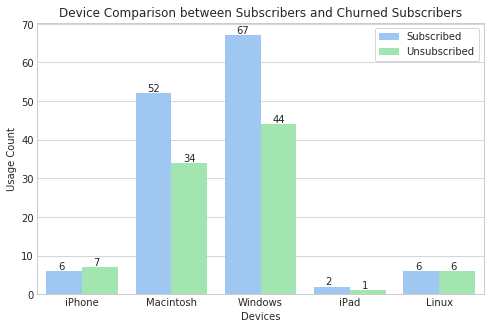

In [117]:
plt.figure(figsize=(8,5))

ax = sns.countplot(x='device', hue='status', data = device_df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Devices');
plt.ylabel('Usage Count');

plt.title('Device Comparison between Subscribers and Churned Subscribers');
plt.legend(frameon=True);

In [118]:
dv_summary = device_df.groupby(['device','status'])['device'].count().reset_index(name='count')
dv_summary.head()

,device,status,count
0,Linux,Subscribed,6
1,Linux,Unsubscribed,6
2,Macintosh,Subscribed,52
3,Macintosh,Unsubscribed,34
4,Windows,Subscribed,67


In [119]:
dv_summary = dv_summary.sort_values(['device','status'])

device_unsubscribed = dv_summary[dv_summary['status']=='Unsubscribed']['count']

device_sum = dv_summary.groupby('device').sum()['count']

churn_rate = device_unsubscribed.values / device_sum.values
print('The churn rate by device is: ')
for i, categ_class in enumerate(dv_summary.device.unique()):
    print(f'{categ_class}: {churn_rate[i]:.2f}%')

The churn rate by device is: 
Linux: 0.50%
Macintosh: 0.40%
Windows: 0.40%
iPad: 0.33%
iPhone: 0.54%


In [120]:
device_df['device_type'] = device_df['device'].apply(lambda x: 'computer' if x in ['iPad','iPhone'] else 'mobile')

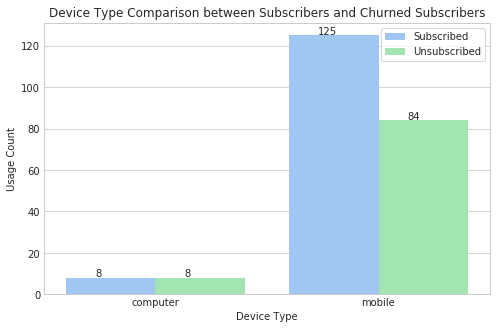

In [121]:
plt.figure(figsize=(8,5))

ax = sns.countplot(x='device_type', hue='status', data = device_df)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Device Type');
plt.ylabel('Usage Count');

plt.title('Device Type Comparison between Subscribers and Churned Subscribers');
plt.legend(frameon=True);

There is a huge difference in size between devices used by both users. There is also a much larger subscribership by mobile users. A large number of these on mobile have stayed subscribed. It might provide some power in our model.

In [122]:
dv_summary = device_df.groupby(['device_type','status'])['device_type'].count().reset_index(name='count')
dv_summary.head()

,device_type,status,count
0,computer,Subscribed,8
1,computer,Unsubscribed,8
2,mobile,Subscribed,125
3,mobile,Unsubscribed,84


In [123]:
dv_summary = dv_summary.sort_values(['device_type','status'])

device_unsubscribed = dv_summary[dv_summary['status']=='Unsubscribed']['count']

device_sum = dv_summary.groupby('device_type').sum()['count']

churn_rate = device_unsubscribed.values / device_sum.values
print('The churn rate by device is: ')
for i, categ_class in enumerate(dv_summary.device_type.unique()):
    print(f'{categ_class}: {churn_rate[i]:.2f}%')

The churn rate by device is: 
computer: 0.50%
mobile: 0.40%


In [124]:
del device_df, device_unsubscribed, device_sum, categ_class, churn_rate
gc.collect();

#### 6 Pages

We explore the relationships between Pages visited by churned users and pages visited by  Subscribed Users. We take a look at the pages themselves to spot any difference.

In [125]:
print('Pages visited by Unsubscribed Users:')
unsub_pages = df.filter('status == "Unsubscribed"').select('page').dropDuplicates().take(20)
unsub_pages

Pages visited by Unsubscribed Users:


[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [126]:
print('Pages visited by Subscribed Users:')
sub_pages = df.filter('status == "Subscribed"').select('page').dropDuplicates().take(20)
sub_pages

Pages visited by Subscribed Users:


[Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [127]:
print(f'Similar Pages: {(np.intersect1d(sub_pages,unsub_pages))}')

Similar Pages: ['About' 'Add Friend' 'Add to Playlist' 'Downgrade' 'Error' 'Help' 'Home'
 'Logout' 'NextSong' 'Roll Advert' 'Save Settings' 'Settings'
 'Submit Upgrade' 'Thumbs Down' 'Thumbs Up' 'Upgrade']


In [128]:
churned_pages = np.setdiff1d(unsub_pages, sub_pages)
print(f'Unique Churned User Pages: {churned_pages}')

Unique Churned User Pages: ['Cancel' 'Cancellation Confirmation' 'Submit Downgrade']


In [129]:
print(f' Unique Subscriber Pages: {np.setdiff1d(sub_pages,unsub_pages)}')

 Unique Subscriber Pages: []


In [130]:
print(f' Unique Subscriber Pages: {np.setdiff1d(sub_pages,unsub_pages)}')

 Unique Subscriber Pages: []


Looking at the above there a no pages unique to Subscribers and our churned Users only have the pages we used in creating the segmentation.
We do however have a number of interesting features in the Similar pages. 

We have 'Add Friend', 'Add to Playlist', 'Error', 'Help', 'Logout', 'NextSong', 'Roll Advert','Thumbs Down', 'Thumbs Up'

In [131]:
pages_df = df.select(['userId','status','page','level'])
pages_df = pages_df.filter(~pages_df.page.isin(list(churned_pages)))
pages_df.show(5)

+------+----------+---------+-----+
|userId|    status|     page|level|
+------+----------+---------+-----+
|100010|Subscribed| NextSong| free|
|100010|Subscribed| NextSong| free|
|100010|Subscribed| NextSong| free|
|100010|Subscribed|Thumbs Up| free|
|100010|Subscribed| NextSong| free|
+------+----------+---------+-----+
only showing top 5 rows



In [132]:
pages_df = pages_df.toPandas()
pages_df.shape

(277987, 4)

We have a large number of interactions with various pages.

We might also want to compare this with level as we can somewhat expect free and paid users to have different behaviours across time.

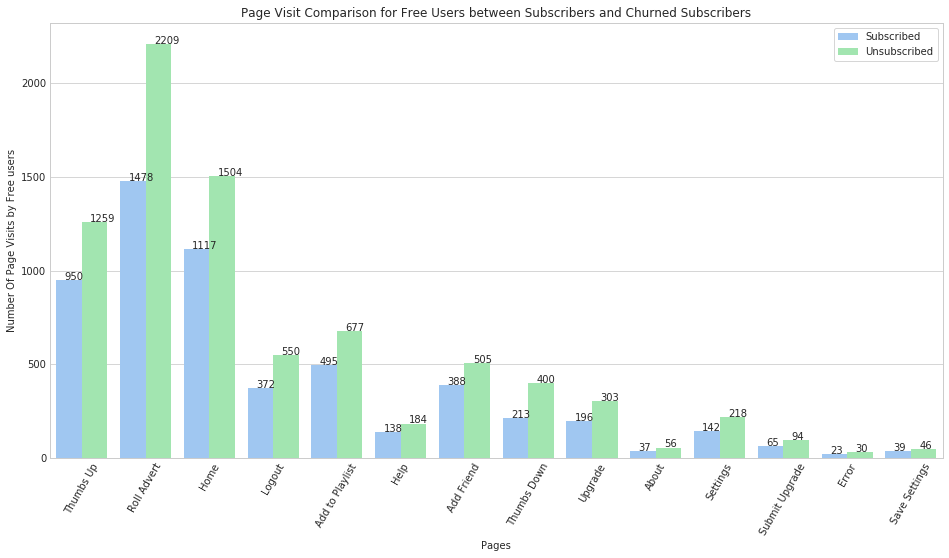

In [133]:
pages_subset = pages_df[(pages_df['page'] != 'NextSong') & (pages_df['level'] == 'free')]

plt.figure(figsize=(16,8))

ax = sns.countplot(x='page', hue='status', data = pages_subset)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Pages');
plt.xticks(rotation=60)
plt.ylabel('Number Of Page Visits by Free users')

plt.title('Page Visit Comparison for Free Users between Subscribers and Churned Subscribers')
plt.legend(frameon=True, loc='best');

Interestingly, we are seeing high activity for the free unsubscribed users. They visit a large number of pages and are very active across the application.

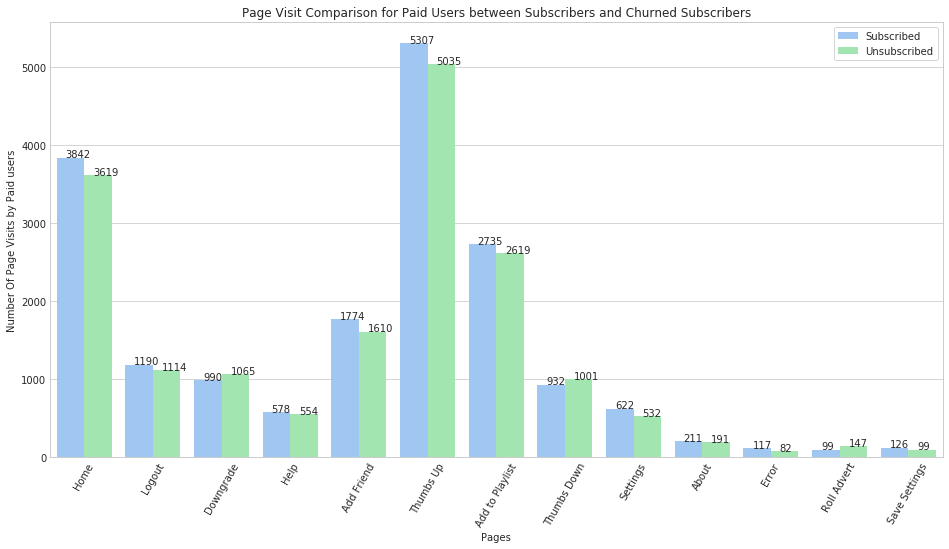

In [134]:
pages_subset = pages_df[(pages_df['page'] != 'NextSong') & (pages_df['level'] == 'paid')]

plt.figure(figsize=(16,8))

ax = sns.countplot(x='page', hue='status', data = pages_subset)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Pages');
plt.xticks(rotation=60)
plt.ylabel('Number Of Page Visits by Paid users')

plt.title('Page Visit Comparison for Paid Users between Subscribers and Churned Subscribers')
plt.legend(frameon=True, loc='best');

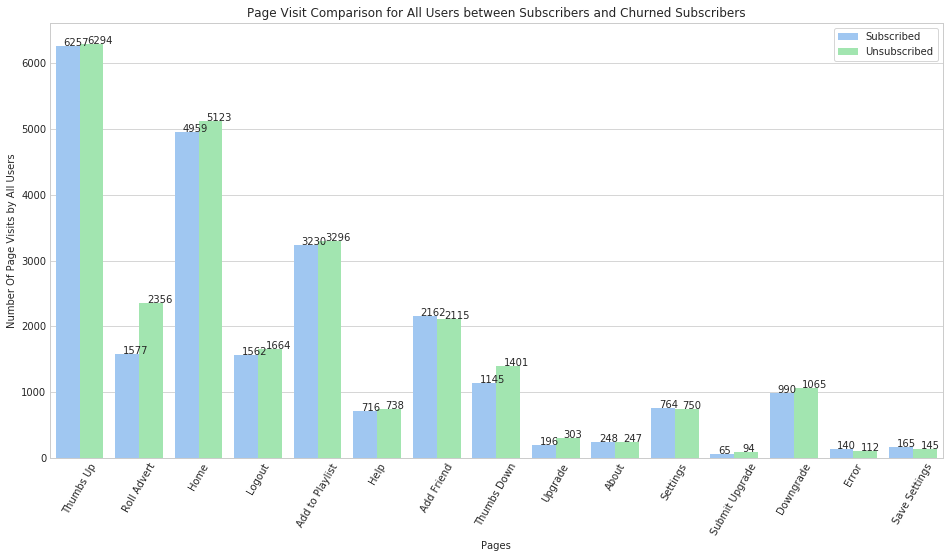

In [135]:
pages_subset = pages_df[(pages_df['page'] != 'NextSong')]

plt.figure(figsize=(16,8))

ax = sns.countplot(x='page', hue='status', data = pages_subset)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Pages');
plt.xticks(rotation=60)
plt.ylabel('Number Of Page Visits by All Users')

plt.title('Page Visit Comparison for All Users between Subscribers and Churned Subscribers')
plt.legend(frameon=True, loc='best');

Across the board, some pages stand out. The Roll advert, The add friend pages, the thumbs down and thumbs up pages.

Now, we finally look at song plays by each user type.

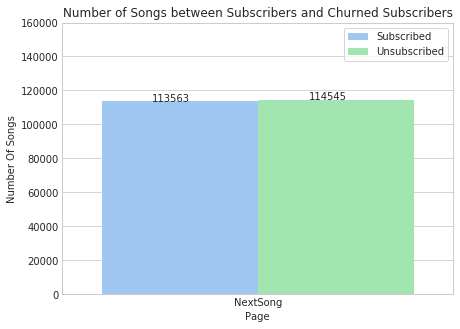

In [137]:
pages_subset = pages_df[pages_df['page'] == 'NextSong']

plt.figure(figsize=(7,5))

ax = sns.countplot(x='page', hue='status', data = pages_subset)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()+0.5))

plt.xlabel('Page');
plt.yticks(range(0,180000, 20000))
plt.ylabel('Number Of Songs')

plt.title('Number of Songs between Subscribers and Churned Subscribers')
plt.legend(frameon=True, loc='best');

We can see a significant number of plays by both users and its not exactly clear who plays more songs in total. But it does seem like a trustworthy feature for our analysis.

Some questions on the validity of roll ads. Some streaming platform put roll ads before streaming content only for free users. We question if this is the same for sparkify.

In [112]:
df.filter('page=="Roll Advert"').count()

3933

In [113]:
df.filter('level=="free"').count()

55721

In [114]:
df.filter('level=="paid" and page=="Roll Advert"').count()

246

It seems some paid users get roll ads.

In [ ]:
del pages_subset, pages_df, churned_pages,
gc.collect();

#### 6 Time On The Platform

It's fairly obvious to try to understand the length of time a user has spent on the platform and to try linking that to the churn rate. Are older users more loyal and less likely to churn?

In [39]:
time_df = df.select(['userId','status','ts','registration']).dropDuplicates()

#create a time partition so we can get the first users date
timewindow = Window.partitionBy("userId").orderBy(desc("ts"))

time_df = time_df.withColumn("rankOfEvent", dense_rank().over(timewindow))

time_df.show(5)

+------+----------+-------------+-------------+-----------+
|userId|    status|           ts| registration|rankOfEvent|
+------+----------+-------------+-------------+-----------+
|100010|Subscribed|1542823952000|1538016340000|          1|
|100010|Subscribed|1542823951000|1538016340000|          2|
|100010|Subscribed|1542823682000|1538016340000|          3|
|100010|Subscribed|1542823567000|1538016340000|          4|
|100010|Subscribed|1542823257000|1538016340000|          5|
+------+----------+-------------+-------------+-----------+
only showing top 5 rows



In [40]:
time_df = time_df.filter(time_df.rankOfEvent == 1)

time_df.show(5)

+------+------------+-------------+-------------+-----------+
|userId|      status|           ts| registration|rankOfEvent|
+------+------------+-------------+-------------+-----------+
|100010|  Subscribed|1542823952000|1538016340000|          1|
|200002|  Subscribed|1542324354000|1536269906000|          1|
|   125|Unsubscribed|1539318918000|1533157139000|          1|
|   124|  Subscribed|1543590766000|1532224335000|          1|
|    51|Unsubscribed|1539761972000|1538080987000|          1|
+------+------------+-------------+-------------+-----------+
only showing top 5 rows



In [41]:
#We caast the date to long, find the time difference in seconds. Divide by 86400 to change to days x1000
time_df = time_df.withColumn('daysSinceRegistration', 
                             (col("ts").cast("long") - col('registration').cast("long"))/86400.)


time_df = time_df.drop('rankOfEvent','registration','ts')

time_df.show(5)

+------+------------+---------------------+
|userId|      status|daysSinceRegistration|
+------+------------+---------------------+
|100010|  Subscribed|    55643.65740740741|
|200002|  Subscribed|    70074.62962962964|
|   125|Unsubscribed|    71316.88657407407|
|   124|  Subscribed|   131555.91435185185|
|    51|Unsubscribed|    19455.84490740741|
+------+------------+---------------------+
only showing top 5 rows



In [42]:
time_df = time_df.toPandas()

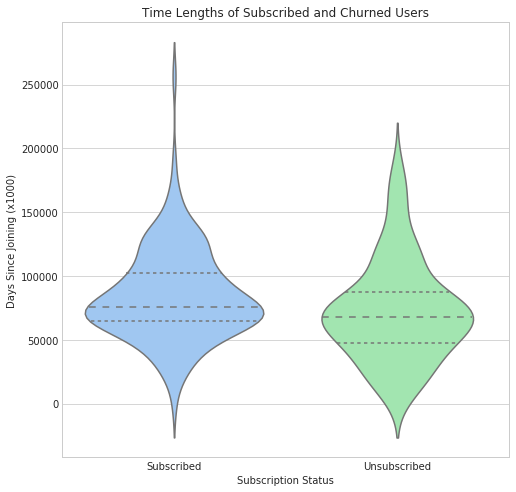

In [43]:
# plot the distribution
plt.figure(figsize=(8,8))
sns.violinplot(x='status',y='daysSinceRegistration', data=time_df, inner='quartile')
plt.ylabel('Days Since Joining (x1000)');
plt.xlabel('Subscription Status');
plt.title('Time Lengths of Subscribed and Churned Users');

As expected, the older users are more likely to stay subscribed. We can see by all quartile comparisons, the subscribed users stay longer.

In [44]:
time_df.groupby('status')['daysSinceRegistration'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Subscribed,133.0,84801.807296,35780.38590,313.726852,64681.840278,75356.365741,102248.865741,256377.673611
Unsubscribed,92.0,72680.852330,39326.42762,5165.115741,47140.245949,68053.888889,87721.481481,188311.782407


This could be a particularly useful feature to keep for our model. We should however remember to scale the days down by (x1000)

In [45]:
del time_df, timewindow
gc.collect();

# Feature Engineering
We have familiarized ourselves with the data. In this segment, we proceed to build out the features to train our model on. To work with the full dataset, you can follow the following steps.

Our feature ideas from the segment above were:

- The Users Level
- The Users Device Type
- The Users Gender

- The Users Time On The Platform In Hours
- The Average Session Length (in hours) 
- The Number of Item Interactions in a Session by Users.
- The Total Number of Song Upvotes (Thumbs Up) per User.
- The Total Number of Song Downvotes (Thumbs Down) per User.
- The Total Number of Friends Added to the Platform.

- Average songs listened per session by users.

We will create this by taking parts of the data and merging each new feature column. In every case where we have multiple instances of data such as in level, we will largely stick to taking maximums, averages or the most current event. We should a number of users equal to the number of distinct users.

We also need to
    1. One hot encode our categorial features
    2. Scale and vectorize our numerical features.

Some General Functions We will Need:

In [23]:
#create a time partition so we can get the users by date
timewindow = Window.partitionBy("userId").orderBy(desc("ts"))

**1. The Users Level**

We create the level fields for the dataframe we are creating.

In [24]:
level_df = df.select(['userId','level','ts']).dropDuplicates()

level_df = level_df.withColumn("rankOfEvent", dense_rank().over(timewindow))

level_df = level_df.filter(level_df.rankOfEvent == 1).drop('rankOfEvent','ts')

In [25]:
level_df.count()

225

In [26]:
level_df.show(4)

+------+-----+
|userId|level|
+------+-----+
|100010| free|
|200002| paid|
|   125| free|
|   124| paid|
+------+-----+
only showing top 4 rows



In [27]:
#Encoding our categorical features
level_df = level_df.withColumn('level',
                          when(col('level') == 'free', 1.0).otherwise(0.0))

In [28]:
level_df.show(4)

+------+-----+
|userId|level|
+------+-----+
|100010|  1.0|
|200002|  0.0|
|   125|  1.0|
|   124|  0.0|
+------+-----+
only showing top 4 rows



**2. The Users Device Type**

We create the device type for the users for the dataframe we are creating. Device types are 'PC' or 'Mobile'

In [29]:
regex = r'(\(?Windows.? | \(?Linux.? | \(?Macintosh.? | \(?iPad.? | \(?iPhone.?)'

get_device_type = udf(lambda x: 'computer' if re.findall(regex, x)[0].strip().strip('(').strip(';') in ['iPad','iPhone'] else 'mobile')


device_df = df.select(['userId','userAgent']).dropDuplicates()

device_df = device_df.withColumn('device_type', get_device_type(device_df.userAgent))

device_df = device_df.drop('userAgent')

In [30]:
device_df.count()

225

In [31]:
device_df.show(4)

+------+-----------+
|userId|device_type|
+------+-----------+
|200021|     mobile|
|   156|     mobile|
|100010|   computer|
|     7|     mobile|
+------+-----------+
only showing top 4 rows



In [32]:
#Encoding our categorical features
device_df = device_df.withColumn('device_type',
                          when(col('device_type') == 'mobile', 1.0).otherwise(0.0))

In [33]:
device_df.show(4)

+------+-----------+
|userId|device_type|
+------+-----------+
|200021|        1.0|
|   156|        1.0|
|100010|        0.0|
|     7|        1.0|
+------+-----------+
only showing top 4 rows



**3. The Users Gender**

We create the gender fields for the dataframe we are creating.

In [34]:
gender_df = df.select(['userId','gender']).dropDuplicates()

In [35]:
gender_df.count()

225

In [36]:
gender_df.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     F|
|    46|     F|
|    41|     F|
|    72|     F|
|300023|     F|
+------+------+
only showing top 5 rows



In [37]:
#Encoding our categorical features
gender_df = gender_df.withColumn('gender',
                          when(col('gender') == 'F', 1.0).otherwise(0.0))

In [38]:
gender_df.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|   1.0|
|    46|   1.0|
|    41|   1.0|
|    72|   1.0|
|300023|   1.0|
+------+------+
only showing top 5 rows



**4. The Users Time On The Platform In Hours**

We fill in the number of days on the platform.

In [39]:
time_df = df.select(['userId','ts','registration']).dropDuplicates()

time_df = time_df.withColumn("rankOfEvent", dense_rank().over(timewindow))

time_df = time_df.filter(time_df.rankOfEvent == 1)

#We cast the date to long, find the time difference in seconds. Divide by 86400 to change to days
time_df = time_df.withColumn('days_from_reg', 
                             (col("ts").cast("long") - col('registration').cast("long"))/86400.)

time_df = time_df.drop('rankOfEvent','registration','ts')

In [40]:
time_df.count()

225

In [41]:
time_df.show(5)

+------+------------------+
|userId|     days_from_reg|
+------+------------------+
|100010| 55643.65740740741|
|200002| 70074.62962962964|
|   125| 71316.88657407407|
|   124|131555.91435185185|
|    51| 19455.84490740741|
+------+------------------+
only showing top 5 rows



**5. Average session length (in hours) and number of item interactions in a session by users.**

We fill in the average session length by users on the platform.

In [42]:
#Calculating summary functions itemsinsession, sessionstart and sessionend
session_df = df.groupby(['userId','sessionId']) \
               .agg(Fmax(col('itemInSession')) \
                    .alias('items_in_session'),
                    Fmin(col('ts')) \
                    .alias('sessionStart'), 
                    Fmax(col('ts')) \
                    .alias('sessionEnd')) \
               .orderBy(asc('userId'), asc('sessionId'))

#Calculating the session length in hours
session_df = session_df.withColumn("session_length", 
                                   Fround((col("sessionEnd") \
                                    .cast("long") - 
                                    col("sessionStart")
                                    .cast("long")) /(1000*3600.), 2))

session_df.show(2)

+------+---------+----------------+-------------+-------------+--------------+
|userId|sessionId|items_in_session| sessionStart|   sessionEnd|session_length|
+------+---------+----------------+-------------+-------------+--------------+
|    10|        9|              71|1538965220000|1538979372000|          3.93|
|    10|      595|             456|1539833923000|1539926798000|          25.8|
+------+---------+----------------+-------------+-------------+--------------+
only showing top 2 rows



In [43]:
#Calculating our averages
session_df = session_df.groupby(['userId']) \
               .agg(avg(col('items_in_session')) \
                    .alias('avg_session_items'),
                    avg(col('session_length')) \
                    .alias('avg_session_length'))

session_df.show(5)

+------+------------------+------------------+
|userId| avg_session_items|avg_session_length|
+------+------------------+------------------+
|100010| 54.42857142857143| 2.572857142857143|
|200002|              80.0|              4.44|
|   125|              10.0|              0.49|
|   124|170.13793103448276|              9.65|
|    51|             251.9|14.541000000000002|
+------+------------------+------------------+
only showing top 5 rows



In [44]:
session_df.count()

225

**6. Total number of song upvotes (Thumbs Up) per User.**

We fill in the average number of songs per session by users on the platform.

In [45]:
#Calculating summary functions itemsinsession, sessionstart and sessionend
upvotes_df = df.select(['userId','page']) \
               .filter(col('page') == 'Thumbs Up')

upvotes_df = upvotes_df.groupby(['userId']) \
               .agg(count(col('page')) \
                    .alias('upvotes'))

upvotes_df.show(5)

+------+-------+
|userId|upvotes|
+------+-------+
|100010|     17|
|200002|     21|
|    51|    100|
|   124|    171|
|     7|      7|
+------+-------+
only showing top 5 rows



In [46]:
upvotes_df.count()

220

In [47]:
upvotes_df = upvotes_df.withColumn("upvotes", 
                                   col("upvotes") \
                                    .cast("float"))


upvotes_df.show(5)

+------+-------+
|userId|upvotes|
+------+-------+
|100010|   17.0|
|200002|   21.0|
|    51|  100.0|
|   124|  171.0|
|     7|    7.0|
+------+-------+
only showing top 5 rows



**7. Total number of song downvotes (Thumbs Down) per User.**

We fill in the average number of songs per session by users on the platform.

In [48]:
#Calculating summary functions itemsinsession, sessionstart and sessionend
downvotes_df = df.select(['userId','page']) \
               .filter(col('page') == 'Thumbs Down')

downvotes_df = downvotes_df.groupby(['userId']) \
               .agg(count(col('page')) \
                    .alias('downvotes'))

downvotes_df.show(5)

+------+---------+
|userId|downvotes|
+------+---------+
|100010|        5|
|200002|        6|
|    51|       21|
|   124|       41|
|     7|        1|
+------+---------+
only showing top 5 rows



In [49]:
downvotes_df.count()

203

In [50]:
downvotes_df = downvotes_df.withColumn("downvotes", 
                                   col("downvotes") \
                                    .cast("float"))


downvotes_df.show(5)

+------+---------+
|userId|downvotes|
+------+---------+
|100010|      5.0|
|200002|      6.0|
|    51|     21.0|
|   124|     41.0|
|     7|      1.0|
+------+---------+
only showing top 5 rows



**8. Total number of friends added to the platform.**

Adding friends to a platform is a measure pf social engagement. Pople typically invite friends to platforms they are invested in.

In [51]:
#Calculating summary functions itemsinsession, sessionstart and sessionend
friends_df = df.select(['userId','page']) \
               .filter(col('page') == 'Add Friend')

friends_df = friends_df.groupby(['userId']) \
               .agg(count(col('page')) \
                    .alias('friends'))

friends_df.show(5)

+------+-------+
|userId|friends|
+------+-------+
|100010|      4|
|200002|      4|
|    51|     28|
|   124|     74|
|     7|      1|
+------+-------+
only showing top 5 rows



In [52]:
friends_df.count()

206

In [53]:
friends_df = friends_df.withColumn("friends", 
                                   col("friends") \
                                    .cast("float"))


friends_df.show(5)

+------+-------+
|userId|friends|
+------+-------+
|100010|    4.0|
|200002|    4.0|
|    51|   28.0|
|   124|   74.0|
|     7|    1.0|
+------+-------+
only showing top 5 rows



**9. Average Number of Songs Listened per Session by Users.**

The average number of songs listened per Session by users is also a metric of engagement between users and the platform.

In [54]:
#Calculating summary functions average songs
songs_df = df.select(['userId','sessionId','page']) \
               .filter(col('page') == 'NextSong')

songs_df = songs_df.groupby(['userId','sessionId']) \
               .agg(count(col('page')) \
                    .alias('songs_count'))

songs_df = songs_df.groupby(['userId']) \
               .agg(avg(col('songs_count')) \
                    .alias('avg_songs_count'))


songs_df.show(5)

+------+------------------+
|userId|   avg_songs_count|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [55]:
songs_df.count()

225

**10. Selecting Our Labels.**
We select our labels from the dataset 

In [56]:
#We select the churn column we defined above
labels_df = df.select(['userId', 'churn']).dropDuplicates()

labels_df = labels_df.withColumn('label', col('churn'))

labels_df = labels_df.drop('churn')

labels_df.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



### Creating Our Final Dataset

Adding friends to a platform is a measure pf social engagement. Pople typically invite friends to platforms they are invested in.

In [57]:
feature_df = level_df.join(device_df, on='userId') \
                      .join(gender_df, on='userId') \
                      .join(time_df, on='userId') \
                      .join(upvotes_df, on='userId') \
                      .join(downvotes_df, on='userId') \
                      .join(session_df, on='userId') \
                      .join(friends_df, on='userId') \
                      .join(songs_df, on='userId') \
                      .join(labels_df, on='userId')

In [58]:
feature_df.show(8)

+------+-----+-----------+------+------------------+-------+---------+------------------+------------------+-------+------------------+-----+
|userId|level|device_type|gender|     days_from_reg|upvotes|downvotes| avg_session_items|avg_session_length|friends|   avg_songs_count|label|
+------+-----+-----------+------+------------------+-------+---------+------------------+------------------+-------+------------------+-----+
|100010|  1.0|        0.0|   1.0| 55643.65740740741|   17.0|      5.0| 54.42857142857143| 2.572857142857143|    4.0|39.285714285714285|    0|
|200002|  0.0|        0.0|   0.0| 70074.62962962964|   21.0|      6.0|              80.0|              4.44|    4.0|              64.5|    0|
|   124|  0.0|        1.0|   1.0|131555.91435185185|  171.0|     41.0|170.13793103448276|              9.65|   74.0|145.67857142857142|    0|
|    51|  0.0|        1.0|   0.0| 19455.84490740741|  100.0|     21.0|             251.9|14.541000000000002|   28.0|             211.1|    1|
|     

In [59]:
feature_df = feature_df.drop('userId')

In [60]:
feature_df.limit(8).toPandas()

,level,device_type,gender,days_from_reg,upvotes,downvotes,avg_session_items,avg_session_length,friends,avg_songs_count,label
0,1.0,0.0,1.0,55643.657407,17.0,5.0,54.428571,2.572857,4.0,39.285714,0
1,0.0,0.0,0.0,70074.629630,21.0,6.0,80.000000,4.440000,4.0,64.500000,0
2,0.0,1.0,1.0,131555.914352,171.0,41.0,170.137931,9.650000,74.0,145.678571,0
3,0.0,1.0,0.0,19455.844907,100.0,21.0,251.900000,14.541000,28.0,211.100000,1
4,1.0,1.0,0.0,72778.182870,7.0,1.0,28.428571,1.462857,1.0,21.428571,0
5,0.0,1.0,0.0,56513.576389,81.0,14.0,154.866667,8.804667,31.0,136.714286,0
6,0.0,1.0,1.0,110751.689815,163.0,29.0,94.216216,5.371892,33.0,81.171429,1
7,0.0,1.0,1.0,23556.018519,58.0,3.0,171.666667,9.143333,11.0,136.666667,0


We are done creating our features for our models. Next we'll get to modelling.

## Modeling
We will split the full dataset into train, test, and validation sets. Then we will proceed to vectorize and normalize our model. Finally, we will test out several of the machine learning methods. 

Our models were selected on explainability and performance and my personal familiarity with these four models for our dataset.

**1. _Logistic Regression_**:
Logistic Regression  Forest Classifier is an ensemble model of Decision Trees that trains the datasets on various subsets of the data and averages out the results from all the trees voting.

**2. _Decision Tree Classifier_**:
A decision tree model is an easily graphical representation of complex rules learned model. They consist of nodes and leaves and at each node a decision tree will make a choice (based on training information) on how best to proceed to classify a model.

**3. _Random Forest Classifier_**:
Random Forest Classifier is an ensemble model of Decision Trees that trains the datasets on various bags of subsets of the data and averages out the results from all the trees voting.

**4. _Gradient Boosted Tree Classifier_**:
Gradient Boosted Trees are another ensemble model also using decision trees. They make decisions using a chain of linked trees, boosting signal across this chain iteratively to minimise loss.

**Evaluation**:
We will evaluate the accuracy of the various models, tuning parameters as necessary and determine the winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, we will be using the `F1` score as the metric to optimize.

Lets split our dataset from here on into train, test and validation columns

In [61]:
train, val, test = feature_df.randomSplit([0.6,0.2,0.2], seed=42)

### Train-Test Splits, Vectorizing And Scaling

We start by vectorizing and scaling our model. 

In [62]:
inputs = feature_df.columns
inputs.pop()
print(inputs)

['level', 'device_type', 'gender', 'days_from_reg', 'upvotes', 'downvotes', 'avg_session_items', 'avg_session_length', 'friends', 'avg_songs_count']


In [63]:
def transform_data(df, inputs):
    
    assembler = VectorAssembler(inputCols=inputs, outputCol='vect_features')
    df = assembler.transform(df)
    
    normalizer  = Normalizer(inputCol="vect_features", outputCol="features")
    df = normalizer.transform(df)

    return df

train = transform_data(train, inputs)
val = transform_data(val, inputs)
test = transform_data(test, inputs)

### Our Models

We can select the models we want to use in prediction.

For this exercise we have selected 3 models.

- Logistic Regression Model
- A Random Forest Classifier
- A GBT Classifier

We'll write a set of functions to speed up model training.

In [64]:
def train_model(model, data):
    '''
    Args:
    model -  A model to train
    data  (spark df) -  A dataset to use in training with a "label" column
    
    Return:
    trained_model - A trained model
    train_time  (float) - The time taken to train the model
    '''  
    
    print(f'training: {model.__class__.__name__}')
    start = time.time() 
    
    #train the model
    trained_model = model.fit(train)
    
    end = time.time()
    print('Training Concluded') 
    
    train_time = end - start
    
    print(f'Model trained in {train_time} seconds')
    
    return trained_model, train_time

 
def predict(model, data):
    '''
    Args:
    model -  A model to make predictions from
    data  (spark df) -  A dataset with "features" columns to make predictions

    Return:
    predicted (spark df) -  A spark df with predictions in the "prediction" column
    prediction_time  (float) - The time taken to make a prediction the model
    '''
    print('Evaluating')
    
    start = time.time() 
    
    predicted = model.transform(data)
    
    end = time.time()
    
    prediction_time = end - start
    
    return predicted, prediction_time


def score(model, data, metric='f1'):
    '''
    Args:
    data (spark df) -  A dataset with a "prediction" column
    metric  (str) -  A scoring metric, defaults to f1.
         scoring options are the default from the Binary Evaluator from spark
    
    Return:
    score - The scorenof the model
    '''
    print('Evaluating Model')
    
    evaluator = MulticlassClassificationEvaluator()
    
    score = evaluator.evaluate(data, {evaluator.metricName: metric})
    
    print(f'The {metric} score for {model.__class__.__name__} is:{score}')
    
    return score

We proceed to instantiate our four models.

In [65]:
# create instances of our models
log_reg = LogisticRegression(maxIter=10)
rand_forest = RandomForestClassifier(seed=42)
gbt_class = GBTClassifier(maxIter=10, seed=42)
tree = DecisionTreeClassifier()

test_models = [log_reg, tree, rand_forest, gbt_class]

Training and evaluating our models. We save the results to a dictionary we can look at for comparison.

In [66]:
evaluation = {}
saved_model = []

for model in test_models:
    model_name = model.__class__.__name__

    #training our model
    trained_model, train_time = train_model(model, train)
    
    #predictions on our val and training dataset
    val_predicted, val_prediction_time = predict(trained_model, val)
    train_predicted, train_prediction_time = predict(trained_model, train)
    
    #scoring our test predictions 
    val_f1_score = score(model, val_predicted, metric='f1')
    val_acc_score = score(model, val_predicted, metric='accuracy')

    
    #scoring our training predictions
    train_f1_score = score(model,  train_predicted, metric='f1')
    train_acc_score = score(model, train_predicted, metric='accuracy')
    
    #saving our metrics
    evaluation[model_name] = {}
    
    evaluation[model_name]['train_time'] = train_time
    
    evaluation[model_name]['val_prediction_time'] = val_prediction_time
    evaluation[model_name]['train_prediction_time'] = train_prediction_time
    
    evaluation[model_name]['val_f1_score'] = val_f1_score
    evaluation[model_name]['val_acc_score'] = val_acc_score
    
    evaluation[model_name]['train_f1_score'] = train_f1_score
    evaluation[model_name]['train_acc_score'] = train_acc_score
    
    saved_model.append(trained_model)

training: LogisticRegression
Training Concluded
Model trained in 273.64803743362427 seconds
Evaluating
Evaluating
Evaluating Model
The f1 score for LogisticRegression is:0.38502673796791437
Evaluating Model
The accuracy score for LogisticRegression is:0.5454545454545454
Evaluating Model
The f1 score for LogisticRegression is:0.4256213123547291
Evaluating Model
The accuracy score for LogisticRegression is:0.5798319327731093
training: DecisionTreeClassifier
Training Concluded
Model trained in 148.19867944717407 seconds
Evaluating
Evaluating
Evaluating Model
The f1 score for DecisionTreeClassifier is:0.4645920117618232
Evaluating Model
The accuracy score for DecisionTreeClassifier is:0.4772727272727273
Evaluating Model
The f1 score for DecisionTreeClassifier is:0.8905975296157267
Evaluating Model
The accuracy score for DecisionTreeClassifier is:0.8907563025210085
training: RandomForestClassifier
Training Concluded
Model trained in 162.4868667125702 seconds
Evaluating
Evaluating
Evaluating

In [67]:
results = pd.DataFrame(evaluation)
results = results.reindex(['train_time','train_prediction_time','val_prediction_time','train_acc_score', 'val_acc_score','train_f1_score','val_f1_score' ])
results

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GBTClassifier
train_time,273.648037,148.198679,162.486867,246.498376
train_prediction_time,0.061871,0.062985,0.085595,0.057929
val_prediction_time,0.110482,0.125148,0.129204,0.151012
train_acc_score,0.579832,0.890756,0.907563,0.991597
val_acc_score,0.545455,0.477273,0.590909,0.545455
train_f1_score,0.425621,0.890598,0.905822,0.991584
val_f1_score,0.385027,0.464592,0.588325,0.542584


Looking at our results, we have four fine models.

Performance by logistic regression and the Decision tree are expectedly lower as they are simpler models. We also have to worry about if they will generalise well on a larger dataset. 

Our Random forest classifier performs best out of the box and is a prime candidate for Tuning. It has a short training time, the best f1 or accuracy scores and is easily explainable. It does however have the longest time on making predictions. 


Our Gradient Boosted Trees are our next bet but they have longer training times and in this sequence, we are seeing a lot of bias/overfit on the training data, though this may be fixed with optimization. But, we will go with Random Forest for the three reasons below:

1. It's initial performace on the F1 Score.
2. It is an explainable model.
3. It's training time is low. 

### Finetuning Our Random Forest Model

We proceed to finetune our random forest model with the aim of optimizing our performance. We will use k-fold cross validation to finetune our model.

In [68]:
rand_fr = RandomForestClassifier(seed=42) 

In [69]:
param_grid = ParamGridBuilder() \
            .addGrid(rand_fr.maxDepth,[2, 5,10,15]) \
            .addGrid(rand_fr.impurity,['gini','entropy']) \
            .addGrid(rand_fr.numTrees,[5, 10,20,30]) \
            .build()

In [70]:
cv = CrossValidator(estimator=rand_fr,
                    estimatorParamMaps=param_grid,
                    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=4,
                    seed=52)

In [71]:
#Sometimes we skip code block, this is to ascertain the evaluation dictionary always exists.
try:
    if evaluation:
        print('Evaluation exists')
except NameError:
    evaluation = {}

Evaluation exists


In [72]:
model = cv

model_name = model.__class__.__name__

#training our model
trained_model, train_time = train_model(cv, train)

best_model = trained_model.bestModel

#predictions on our val and training dataset
val_predicted, val_prediction_time = predict(trained_model, val)
train_predicted, train_prediction_time = predict(trained_model, train)

#scoring our test predictions 
val_f1_score = score(cv, val_predicted, metric='f1')
val_acc_score = score(cv, val_predicted, metric='accuracy')


#scoring our training predictions
train_f1_score = score(cv,  train_predicted, metric='f1')
train_acc_score = score(cv, train_predicted, metric='accuracy')

#saving our metrics
evaluation[model_name] = {}
    
evaluation[model_name]['train_time'] = train_time

evaluation[model_name]['val_prediction_time'] = val_prediction_time
evaluation[model_name]['train_prediction_time'] = train_prediction_time

evaluation[model_name]['val_f1_score'] = val_f1_score
evaluation[model_name]['val_acc_score'] = val_acc_score

evaluation[model_name]['train_f1_score'] = train_f1_score
evaluation[model_name]['train_acc_score'] = train_acc_score

training: CrossValidator
Training Concluded
Model trained in 5824.59509396553 seconds
Evaluating
Evaluating
Evaluating Model
The f1 score for CrossValidator is:0.5670519956234242
Evaluating Model
The accuracy score for CrossValidator is:0.5681818181818182
Evaluating Model
The f1 score for CrossValidator is:0.7194514169304085
Evaluating Model
The accuracy score for CrossValidator is:0.7310924369747899


### Model Performance

Now that we have successfully trained a new model, we can look at its performance. Model performance and explainability are extremely important for our use cases. We do not want strict black box models with low explainability. We also want models with high performance.

We can see results from our gridsearch tuning and how it compares on performance.

In [86]:
grid_results = pd.DataFrame(evaluation)
grid_results = grid_results.reindex(['train_time','train_prediction_time','val_prediction_time','train_acc_score', 'val_acc_score','train_f1_score','val_f1_score'])
grid_results

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GBTClassifier,CrossValidator
train_time,273.648037,148.198679,162.486867,246.498376,5824.595094
train_prediction_time,0.061871,0.062985,0.085595,0.057929,0.026253
val_prediction_time,0.110482,0.125148,0.129204,0.151012,0.065632
train_acc_score,0.579832,0.890756,0.907563,0.991597,0.731092
val_acc_score,0.545455,0.477273,0.590909,0.545455,0.568182
train_f1_score,0.425621,0.890598,0.905822,0.991584,0.719451
val_f1_score,0.385027,0.464592,0.588325,0.542584,0.567052


Our Tree is definitely not overfitting on the dataset and is much faster at prediction but we also get a worse score on the test. This could be because by the cross validation strategy, our model is seeing less data. It could be generalizing better. We can see more by looking at its performance on test data.

### Comparing CV Results to our Old Results

We take a look at the results from the cross validator on test data

Our old random Forest Model:

In [109]:
test_predicted, test_prediction_time = predict(saved_model[2], test) 
score(saved_model[2],  test_predicted, metric='f1')
score(saved_model[2], test_predicted, metric='accuracy')

Evaluating
Evaluating Model
The f1 score for RandomForestClassificationModel is:0.49714285714285716
Evaluating Model
The accuracy score for RandomForestClassificationModel is:0.5


0.5

Our New CV random Forest Model:

In [110]:
test_predicted, test_prediction_time = predict(best_model, test)
score(best_model,  test_predicted, metric='f1')
score(best_model, test_predicted, metric='accuracy')

Evaluating
Evaluating Model
The f1 score for RandomForestClassificationModel is:0.45925925925925926
Evaluating Model
The accuracy score for RandomForestClassificationModel is:0.4666666666666667


0.4666666666666667

In [103]:
print(best_model.params)

[Param(parent='RandomForestClassifier_662fdd0a8448', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'), Param(parent='RandomForestClassifier_662fdd0a8448', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'), Param(parent='RandomForestClassifier_662fdd0a8448', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'), Param(parent='RandomForestClassifier_662fdd0a8448', name='featuresCol', doc='features column name'), Param(parent='RandomForestClassifier_662fdd0a8448', name='impurity', doc='Criterion use

We can also see the average f1 scores on crossvalidation from training our model.

In [74]:
trained_model.avgMetrics

[0.7062945389247617,
 0.67329171595238,
 0.7097611181375751,
 0.7024858467231032,
 0.7093666866740898,
 0.6518001492266052,
 0.7193839948712513,
 0.7191253561483768,
 0.6648435800390924,
 0.6790378820301644,
 0.6998987474127687,
 0.6730104780902917,
 0.6917294964920981,
 0.6720091816274201,
 0.6707848955294096,
 0.6603606235602738,
 0.6369079015918097,
 0.6931817272312257,
 0.6655296602931797,
 0.692661786031527,
 0.6696933912931485,
 0.6609239817379169,
 0.6310375510115652,
 0.64777236918741,
 0.6369079015918097,
 0.6931817272312257,
 0.6655296602931797,
 0.682072647402461,
 0.6696933912931485,
 0.6609239817379169,
 0.6310375510115652,
 0.6650300876556172]

### Model Explainability

On model explainability, we are searching for how transparent our model is. How well does it explain what it does and why it do so? What can we learn from our model that we can apply to real life that may be useful in preventing churn.

We can also take a look at feature importance as ranked by our model.

In [111]:
feature_importance = list(best_model.featureImportances.toArray())
feature_imp_df = pd.DataFrame(list(zip(inputs, feature_importance)),
             columns =['Feature Name','Feature Importance'])
feature_imp_df = feature_imp_df.sort_values('Feature Importance', ascending=False)
feature_imp_df

,Feature Name,Feature Importance
5,downvotes,0.468913
8,friends,0.221722
4,upvotes,0.101006
1,device_type,0.062207
2,gender,0.050000
9,avg_songs_count,0.038072
0,level,0.030039
7,avg_session_length,0.017479
6,avg_session_items,0.010563
3,days_from_reg,0.000000


Plotting a graph of feature importance

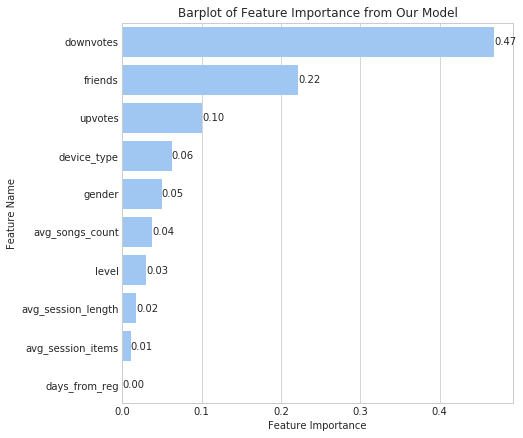

In [107]:
#sort outputs here
f, ax = plt.subplots(figsize=(7,7))
sns.barplot(y='Feature Name', x='Feature Importance', data=feature_imp_df, color=sns.color_palette()[0], ax=ax)
ax.set_title('Barplot of Feature Importance from Our Model');

for i in range(feature_imp_df.shape[0]):
    values = feature_imp_df['Feature Importance'].iloc[i]
    text = f'{values:.2f}'
    ax.text(values, i, text, va='center')

One last position on model explainability with random forests is how we can get even more explainability on how our model makes decision.

In [78]:
print(best_model.toDebugString)

RandomForestClassificationModel (uid=RandomForestClassifier_662fdd0a8448) with 20 trees
  Tree 0 (weight 1.0):
    If (feature 5 <= 4.439678785521483E-5)
     If (feature 8 <= 1.2365593215008636E-4)
      Predict: 0.0
     Else (feature 8 > 1.2365593215008636E-4)
      Predict: 1.0
    Else (feature 5 > 4.439678785521483E-5)
     If (feature 9 <= 0.001807762441263793)
      Predict: 0.0
     Else (feature 9 > 0.001807762441263793)
      Predict: 1.0
  Tree 1 (weight 1.0):
    If (feature 8 <= 4.0360017568446605E-4)
     If (feature 5 <= 2.091842101810228E-4)
      Predict: 0.0
     Else (feature 5 > 2.091842101810228E-4)
      Predict: 1.0
    Else (feature 8 > 4.0360017568446605E-4)
     Predict: 1.0
  Tree 2 (weight 1.0):
    If (feature 4 <= 0.00236160222498737)
     If (feature 5 <= 2.091842101810228E-4)
      Predict: 0.0
     Else (feature 5 > 2.091842101810228E-4)
      Predict: 1.0
    Else (feature 4 > 0.00236160222498737)
     Predict: 1.0
  Tree 3 (weight 1.0):
    If (featu

**More Insight Into Our Features Plotting A Tree With Dtreeviz**

To get better features, we can also look at something like the decision tree to see how it splits the data. This is a useful business case for which we can see our model explainability being very useful.

In [ ]:
!pip install dtreeviz;
from dtreeviz.models.spark_decision_tree import ShadowSparkTree;
from dtreeviz import trees;

In [80]:
features = inputs
target = "label"

In [81]:
dataset = train_predicted.toPandas()[features + [target]]

In [82]:
spark_dtree = ShadowSparkTree(saved_model[1], 
                              dataset[features], 
                              dataset[target], 
                              feature_names=features, 
                              target_name=target, 
                              class_names=[0, 1])

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


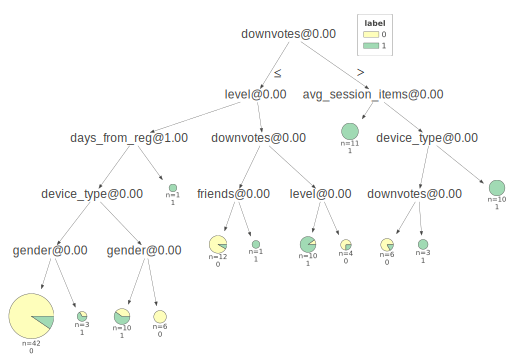

In [83]:
trees.dtreeviz(spark_dtree, fancy=False)

A sample run on this chart says, if downvotes are greater than 0.0.., and session items are less than 0, then we find 11 users who churned which makes complete sense. We should remember that the scaling on this chart is due to normalization.

# Conclusion
We completed and successfully trained and our model using pyspark on a small (124MB) dataset. We cleaned our dataset, analysed our features, created a new feature set and fed that to a machine learning model to predict cutomer churn. However there are still a number of improvements we can make to this model now and in the future.

The business case for using this model would be to prevent Customer Churn. The business needs to understand how and why customers are leaving and perhaps offer incentives or alter experiences to prevent this from happening. Understanding the model goes a long way to doing this and we should always keep this in mind for future uodates.

Suggested Improvements we could make to this model: 
- Expanding our grid criteria to seek better values
- Re-engineering our features with what we have learnt from this model.
- Training on the large sparkify dataset to and viewing how well it generalizes on predicting churn.

In improving and deploying our model we should also anticipate some other issues.

Problems might show up with deployment and monitoring as well as maintainance of this model on the server. It is important to also check the cost of deploying this model on server and business resources.

# References



- https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
- https://stackoverflow.com/questions/33287886/replace-empty-strings-with-none-null-values-in-dataframe
- https://stats.stackexchange.com/questions/424263/should-exploratory-data-analysis-include-validation-set
- https://stackoverflow.com/questions/54411446/pyspark-subtract-two-timestamp-columns-and-give-back-difference-in-minutes-usi
- https://www.vox.com/2014/8/18/6003271/why-are-songs-3-minutes-long
- https://sparkbyexamples.com/pyspark/pyspark-timestamp-difference-seconds-minutes-hours/
- https://sparkbyexamples.com/pyspark/pyspark-timestamp-difference-seconds-minutes-hours/
- https://cprosenjit.medium.com/9-classification-methods-from-spark-mllib-we-should-know-c41f555c0425
- https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_spark_visualisations.ipynb
- https://github.com/parrt/dtreeviz
- https://explained.ai/decision-tree-viz/index.html#sec:1.5.1

In [112]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analysing Customer Churn With Sparkify.ipynb'])

0